## Applying Tabular Methods

### Stochastic Q Learning

Import Statements

In [1]:
import gym as gym
from gym import spaces
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np
import pickle

In [2]:
class StochasticFrozenLakeEnv(gym.Env):
    metadata = {'render.modes': []}

    def __init__(self, gamma=0.9, alpha=0.1, max_timestamp=10):
        self.gamma = gamma
        self.alpha = alpha
        
        self.obs_space = spaces.Discrete(16)
        self.action_space = spaces.Discrete(4)
        self.max_timestamp = max_timestamp
        self.timestep = 0

        self.state = np.zeros((4, 4))
        self.myskater = np.asarray([0, 0])
        self.goal_loc = np.asarray([3, 3])
        self.gem_loc = [np.asarray([0, 2]), np.asarray([3, 2])]
        self.hole_loc = [np.asarray([1, 3]), np.asarray([2, 0])]

        self.state[tuple(self.myskater)] = 0.2
        self.state[tuple(self.goal_loc)] = 0.8
        for pos in self.gem_loc:
            self.state[tuple(pos)] = 0.5
        for pos in self.hole_loc:
            self.state[tuple(pos)] = 0.4

        self.prev_state = np.zeros((4, 4))
        self.prev_action = None
        self.penalty_counter = 0
        self.flag_out_grid = 0

    def step(self, action):
        self.prev_state = np.copy(self.state)
        self.prev_action = action
        self.flag_out_grid = 0

        randomness = [0.35, 0.15, 0.35, 0.15]  # probability for each action
        action = np.random.choice(4,p=randomness)

        if action == 0:
            self.myskater[0] += 1
        elif action == 1:
            self.myskater[0] -= 1
        elif action == 2:
            self.myskater[1] += 1
        elif action == 3:
            self.myskater[1] -= 1

        self.myskater = np.clip(self.myskater, 0, 3)

        prev_state_positions = np.argwhere(self.prev_state == 0.2)
        if len(prev_state_positions) > 0:
            if np.array_equal(self.myskater, prev_state_positions[0]):
                while action == self.prev_action:
                    action = np.random.choice(4, p=randomness)
                self.flag_out_grid = 1

        self.state = np.zeros((4, 4))
        self.state[tuple(self.myskater)] = 0.2
        self.state[tuple(self.goal_loc)] = 0.8
        for pos in self.gem_loc:
            self.state[tuple(pos)] = 0.5
        for pos in self.hole_loc:
            self.state[tuple(pos)] = 0.4

        obs = self.state.flatten()
        reward = self.calculate_reward()
        penalty = any(np.array_equal(self.myskater, pos) for pos in self.hole_loc)
        if penalty:
            self.penalty_counter += 1
        self.timestep += 1

        terminated = True if np.array_equal(self.myskater, self.goal_loc) else self.timestep >= self.max_timestamp
        truncated = True if np.any((self.myskater < 0) | (self.myskater > 3)) else False
        if terminated or truncated:
            self.flag_out_grid=1
            self.state = np.copy(self.prev_state) 

            # Check if there are any positions with a value of 0.2
            positions_with_value_0_2 = np.argwhere(self.state == 0.2)

            if len(positions_with_value_0_2) > 0:
                # Ensure that the index is within bounds
                index = np.random.randint(len(positions_with_value_0_2))
                self.myagent = positions_with_value_0_2[index]
                
        info = {}

        return self.state.flatten(), reward, terminated, truncated, info
        
    def reset(self, **kwargs):
        self.state = np.zeros((4, 4))
        self.myskater = np.asarray([0, 0])
        self.state[tuple(self.myskater)] = 0.2
        self.state[tuple(self.goal_loc)] = 0.8

        for pos in self.gem_loc:
            self.state[tuple(pos)] = 0.5
        for pos in self.hole_loc:
            self.state[tuple(pos)] = 0.4

        self.prev_state = np.zeros((4, 4))
        self.prev_action = None
        self.flag_out_grid = 0 
        
        obs = self.state.flatten()
        self.timestep = 0
        info = {}
        self.penalty_counter = 0
        return obs, info

    def calculate_reward(self):
        prev_myskateritions = np.argwhere(self.prev_state == 0.2)
        if prev_myskateritions.size == 0:
            prev_myskaterition = self.myskater
        else:
            prev_myskaterition = prev_myskateritions[0]

        # Calculating distance to goal before and after the step
        prev_distance_to_goal = np.linalg.norm(self.goal_loc - prev_myskaterition)
        current_distance_to_goal = np.linalg.norm(self.goal_loc - self.myskater)


        ## REWARDS SET #############
        if np.array_equal(self.myskater, self.goal_loc):
            reward = 10  # Positive reward for reaching goal
        elif np.array_equal(self.myskater, self.hole_loc[0]):
            reward = -5  # negative reward for reaching holes 1
        elif np.array_equal(self.myskater, self.hole_loc[1]):
            reward = -6   # negative reward for reaching holes 2
        elif np.array_equal(self.myskater, self.gem_loc[0]):
            reward = 5   # positive reward for reaching gems 1
        elif np.array_equal(self.myskater, self.gem_loc[1]):
            reward = 6  # positive reward for reaching gems 2
        elif current_distance_to_goal < prev_distance_to_goal:
            reward = 1  # Positive reward for moving closer to goal
        elif current_distance_to_goal > prev_distance_to_goal:
            reward = -1  # Negative reward for moving away to goal
        else:
            reward = -0.1  # Slight negative reward for no change
        ##########################
        
        return reward
    
    def get_penalty_count(self):
        return self.penalty_counter

    def render(self):
        fig, ax = plt.subplots()
        plt.title('Frozen Lake Environment')

        # Load and display the background image
        background_img = plt.imread('images/frozen_lake.jpg')
        ax.imshow(background_img, extent=(-0.5, 3.5, -0.5, 3.5), origin='upper')

       
        skater_img = plt.imread('images/icons8-skateboard-100.png')
        hole_img = plt.imread('images/icons8-hole-100.png')
        gem_img = plt.imread('images/icons8-gems-100.png')
        goal_img = plt.imread('images/icons8-flag-100.png')
        skater_hole_drown_img = plt.imread('images/agent_hole_drown.png')
        skater_gem_lottery_img = plt.imread('images/agent_gems_lottery.png')
        agent_flag_winner_img = plt.imread('images/agent_flag_winner.png')
        agent_grid_cross_img = plt.imread('images/agent_grid_cross.png')

        # Plot Skater
        myskater = self.myskater
        if self.flag_out_grid:
            skater_img = agent_grid_cross_img
        agent_box = AnnotationBbox(OffsetImage(skater_img, zoom=0.4), myskater, frameon=False)
        ax.add_artist(agent_box)

        # Plot Holes
        for hole_loc in self.hole_loc:
            hole_loc = hole_loc
            if np.array_equal(self.myskater, hole_loc):
                hole_img = skater_hole_drown_img
            else:
                hole_img = plt.imread('images/icons8-hole-100.png')
            rock_box = AnnotationBbox(OffsetImage(hole_img, zoom=0.4), hole_loc, frameon=False)
            ax.add_artist(rock_box)

        # Plot Gems
        for gem_loc in self.gem_loc:
            gem_loc = gem_loc
            if np.array_equal(self.myskater, gem_loc):
                gem_img = skater_gem_lottery_img
            else:
                gem_img = plt.imread('images/icons8-gems-100.png')
            battery_box = AnnotationBbox(OffsetImage(gem_img, zoom=0.4), gem_loc, frameon=False)
            ax.add_artist(battery_box)

        # Plot goal
        goal_loc = self.goal_loc
        goal_loc = self.goal_loc
        if np.array_equal(self.myskater, goal_loc):
            goal_img = agent_flag_winner_img
        else:
            goal_img = plt.imread('images/icons8-flag-100.png')
        goal_box = AnnotationBbox(OffsetImage(goal_img, zoom=0.4), goal_loc, frameon=False)
        ax.add_artist(goal_box)

        plt.xticks(np.arange(-0.5, 4.5, 1))
        plt.yticks(np.arange(-0.5, 4.5, 1))
        plt.gca().set_xticklabels(np.arange(-0.5, 4.5, 1))
        plt.gca().set_yticklabels(np.arange(-0.5, 4.5, 1))
        plt.show()

    def obs_space_to_index(self, obs):
        myskater = np.argwhere(obs.reshape(4, 4) == 0.2)
        if myskater.size == 0:
            return 0 
        return myskater[0, 0] * 4 + myskater[0, 1]


In [3]:
env_stoc_q = StochasticFrozenLakeEnv()

epsilon = 1.0  # Initial exploration rate
epsilon_min = 0.01  # Minimum exploration rate
gamma = 0.95  # Discount factor
alpha = 0.15  # Learning rate
decay_rate = 0.995  # Epsilon decay rate per episode
total_episodes = 1000 
max_timestamp = 10
qt = np.zeros((env_stoc_q.obs_space.n, env_stoc_q.action_space.n))

rewards_epi = []
epsilon_values = []
steps_per_episode = []
penalties_per_episode = []

final_state = None
for episode in range(total_episodes):
    state, _ = env_stoc_q.reset()
    state_index = env_stoc_q.obs_space_to_index(state)
    total_rewards = 0
    total_steps = 0  
    action = env_stoc_q.action_space.sample() if np.random.uniform(0, 1) < epsilon else np.argmax(qt[state_index])

    while True:
        next_state, reward, terminated, truncated, _ = env_stoc_q.step(action)
        total_steps += 1 
        next_strt_idx = env_stoc_q.obs_space_to_index(next_state)
        next_action = env_stoc_q.action_space.sample() if np.random.uniform(0, 1) < epsilon else np.argmax(qt[next_strt_idx])
        qt[state_index, action] = qt[state_index, action] + alpha * (reward + gamma * qt[next_strt_idx, next_action] - qt[state_index, action])
        state_index, action = next_strt_idx, next_action
        total_rewards += reward
        
        if terminated or truncated:
            break
    
    penalties_per_episode.append(env_stoc_q.get_penalty_count())  
    
    # Q-table for every 100 episodes
    if (episode + 1) % 100 == 0:
        print(f"Episode: {episode + 1}")
        print("Q-table:")
        print(qt)

        # average penalties
        avg_penalty = np.mean(penalties_per_episode[-100:])
        print(f"Average Penalties in Last 100 Episodes: {avg_penalty}")

    epsilon = max(epsilon_min, epsilon * decay_rate)
    epsilon_values.append(epsilon)
    rewards_epi.append(total_rewards)
    steps_per_episode.append(total_steps)

    if (episode + 1) % 100 == 0:
        average_steps = np.mean(steps_per_episode[-100:])
        print(f"Episode: {episode + 1}, Average Steps: {average_steps}")

    if episode == total_episodes - 1:
        final_state = env_stoc_q.state


Episode: 100
Q-table:
[[ 0.884182    1.30796692  2.78665189  1.49728285]
 [ 2.75724562  2.5129886   4.8144802   1.92199061]
 [ 0.          0.          0.          0.        ]
 [-0.37141941 -0.96013042 -1.00686475 -1.46901917]
 [-3.34695982 -2.64672654 -3.06026345 -0.40319783]
 [ 0.2864261   0.43104706  0.51565151  1.22370963]
 [-1.01743945  1.06395633  2.1270275   2.51635968]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [-0.35781502 -0.13008573 -0.57622004 -0.16558562]
 [ 4.42107267  0.03355901  2.49717014  1.27693664]
 [ 0.23483546  2.21813139  0.06951418  0.79570972]
 [-1.83336079 -1.69245627 -0.89541104 -2.18432665]
 [ 2.67283586  2.76507066  2.03724955  4.05543027]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
Average Penalties in Last 100 Episodes: 1.22
Episode: 100, Average Steps: 9.7
Episode: 200
Q-table:
[[ 2.10676134  3.31341259  4.64971965  1.51658731]
 [ 3.83166

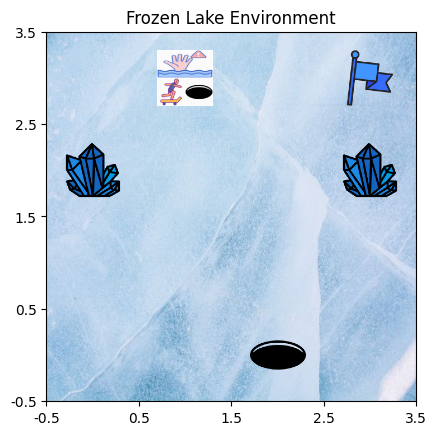

In [4]:
env_stoc_q.state = final_state
env_stoc_q.render()

Step 2:
Save the Q-table/Policy table as a pickle file or h5 of the trained model and attach it to your assignment submission.

In [5]:
import pickle
with open("models/charviku_assignment1_q_table_stochastic.pkl", 'wb') as file:
    pickle.dump(qt, file)

Step 3:

Provide the evaluation results:

(a) Print the initial Q-table and the trained Q-table

(b) Plot the total reward per episode graph (x-axis: episode, y-axis: total reward per episode).

(c) Plot the epsilon decay graph (x-axis: episode, y-axis: epsilon value)

(d) Run your environment for at least 10 episodes, where the agent chooses only greedy actions from the learned policy. Include a plot of the total reward per episode.

In [6]:
initial_qt = np.zeros((env_stoc_q.obs_space.n, env_stoc_q.action_space.n))
print("Initial Q-table:")
print(initial_qt)

Initial Q-table:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [7]:
print("Trained Q-table:")
print(qt)

Trained Q-table:
[[ 6.74574731  7.98773687  7.79491547 11.42374623]
 [ 7.30737039 14.92416809  7.33342041  7.73039668]
 [ 0.          0.          0.          0.        ]
 [ 7.92115663 -0.54808768  0.2274455   0.19535113]
 [ 1.57860959  8.60914245  1.98207557  2.85108172]
 [ 5.17549658  5.42421783  4.27426562 13.88123288]
 [ 2.26907075 13.48057748  4.35035038  5.62945036]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [14.81364408  6.05700591  4.3818208   4.86269227]
 [ 6.9975676   6.09267742 21.36911632  8.6365104 ]
 [ 3.75100458  7.65803597  9.08050269 32.08647772]
 [ 2.81105453 10.17297351  3.39072454  1.67458786]
 [ 5.1361183   4.80621217  5.37531758 14.60465138]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]


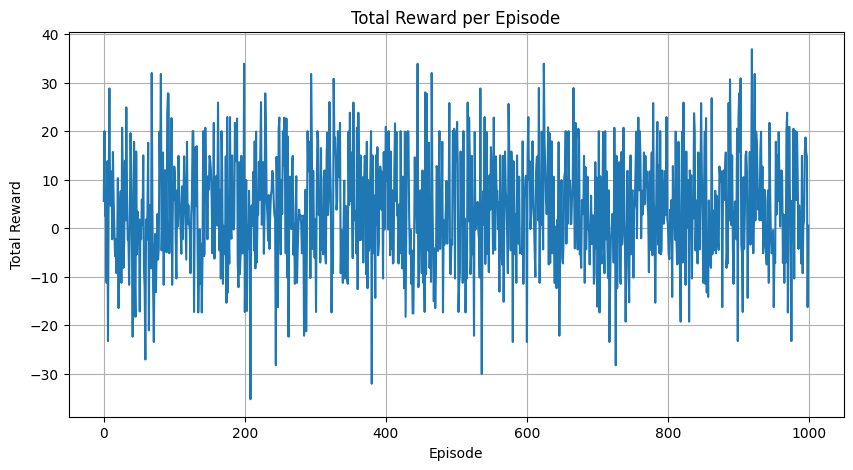

In [8]:
# total reward per episode graph
plt.figure(figsize=(10, 5))
plt.plot(rewards_epi)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode')
plt.grid(True)
plt.show()


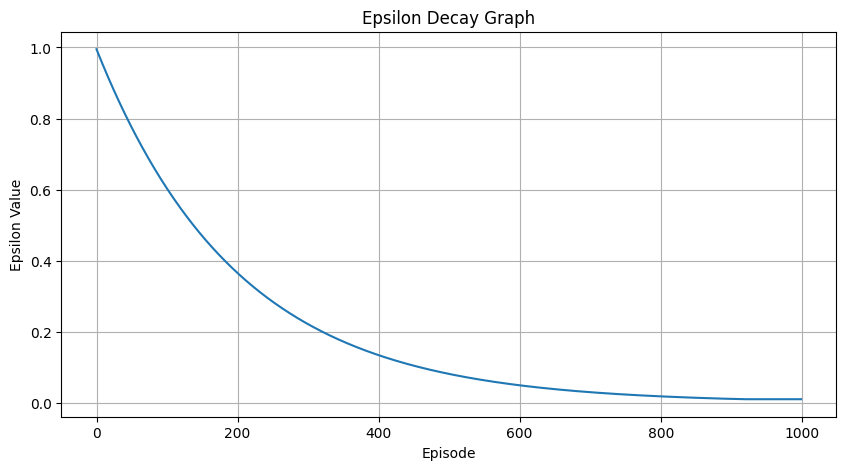

In [9]:
# epsilon decay graph
plt.figure(figsize=(10, 5))
plt.plot(epsilon_values)
plt.xlabel('Episode')
plt.ylabel('Epsilon Value')
plt.title('Epsilon Decay Graph')
plt.grid(True)
plt.show()

Episode 1000 Reward: -4.5
Episode 1000 Reward: 28.9
Episode 1000 Reward: -3.4
Episode 1000 Reward: -3.4
Episode 1000 Reward: 2.9
Episode 1000 Reward: 12.5
Episode 1000 Reward: 5.6
Episode 1000 Reward: 9.7
Episode 1000 Reward: 14.8
Episode 1000 Reward: -5.2


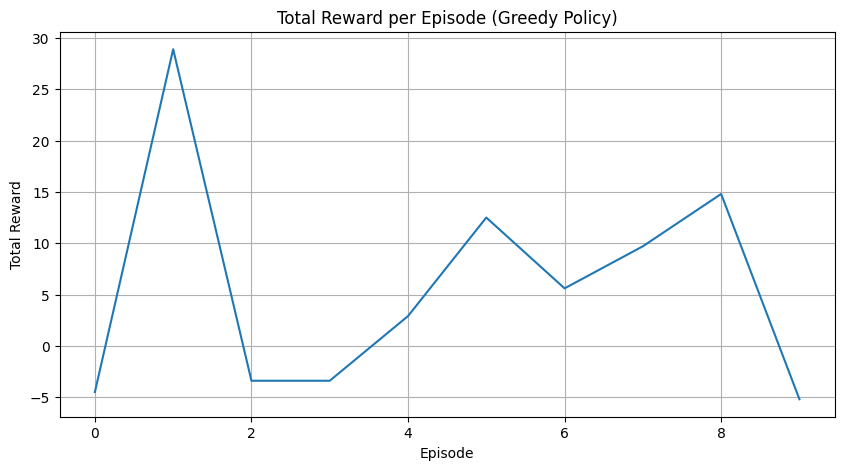

In [10]:
greedy_rewards = []
for _ in range(10):
    total_reward = 0
    state, _ = env_stoc_q.reset()
    state_index = env_stoc_q.obs_space_to_index(state)

    while True:
        action = np.argmax(qt[state_index])
        next_state, reward, terminated, truncated, _ = env_stoc_q.step(action)
        next_strt_idx = env_stoc_q.obs_space_to_index(next_state)
        total_reward += reward
        state_index = next_strt_idx
        if terminated or truncated:
            print(f"Episode {episode + 1} Reward: {round(total_reward, 4)}")
            break

    greedy_rewards.append(total_reward)

# total rewards for 10 episodes
plt.figure(figsize=(10, 5))
plt.plot(greedy_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode (Greedy Policy)')
plt.grid(True)
plt.show()

Step 4. Hyperparameter Tuning: Select at least two hyperparameters to tune to get better results for Q-learning.
You can explore hyperparameter tuning libraries, e.g. Optuna or make it manually. Parameters to
tune (select 2):

• Discount factor (γ)

• Epsilon decay rate

• Epsilon min/max values

• Number of episodes

• Max timesteps

Try at least 3 different values for each of the parameters that you choose

In [11]:
performance_dict = {}

def training_loop(env, g , max_timestamp):
    alpha = 0.15  # Learning rate
    gamma = g  # Discount factor
    epsilon = 1.0  # Initial exploration rate
    epsilon_min = 0.01  # Minimum exploration rate
    decay_rate = 0.995  # Epsilon decay rate per episode
    total_episodes = 1000
    max_timestamp = max_timestamp

    qt = np.zeros((env.obs_space.n, env.action_space.n))

    rewards_epi = []
    epsilon_values = []
    steps_per_episode = []
    penalties_per_episode = []

    final_state = None
    for episode in range(total_episodes):
        state, _ = env.reset()
        state_index = env.obs_space_to_index(state)
        total_rewards = 0
        total_steps = 0 
        action = env.action_space.sample() if np.random.uniform(0, 1) < epsilon else np.argmax(qt[state_index])

        while True:
            next_state, reward, terminated, truncated, _ = env.step(action)
            total_steps += 1 
            next_strt_idx = env.obs_space_to_index(next_state)
            next_action = env.action_space.sample() if np.random.uniform(0, 1) < epsilon else np.argmax(qt[next_strt_idx])
            qt[state_index, action] = qt[state_index, action] + alpha * (reward + gamma * qt[next_strt_idx, next_action] - qt[state_index, action])
            state_index, action = next_strt_idx, next_action
            total_rewards += reward
            
            if terminated or truncated:
                break
        
        penalties_per_episode.append(env.get_penalty_count())              
        epsilon = max(epsilon_min, epsilon * decay_rate)
        epsilon_values.append(epsilon)
        rewards_epi.append(total_rewards)
        steps_per_episode.append(total_steps)

        if episode == total_episodes - 1:
            final_state = env.state
        
    final_reward = np.mean(rewards_epi[-100:]) 
    performance_dict[(alpha, gamma, max_timestamp)] = final_reward
    return qt, rewards_epi, epsilon_values, final_state
        


In [12]:
def evaluate_loop(env, max_timestamp, gamma, qt, rewards_epi, epsilon_values, final_state):
    print(f"Max Timestamp, Gamma:  {max_timestamp}, {gamma}")

    initial_qt = np.zeros((env.obs_space.n, env.action_space.n))
    print("Initial Q-table:")
    print(initial_qt)
    print("\nTrained Q-table:")
    print(qt)


    plt.figure(figsize=(10, 5))
    plt.plot(rewards_epi)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Total Reward per Episode')
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(epsilon_values)
    plt.xlabel('Episode')
    plt.ylabel('Epsilon Value')
    plt.title('Epsilon Decay Graph')
    plt.grid(True)
    plt.show()

    greedy_rewards = []
    for _ in range(10):
        total_reward = 0
        state, _ = env.reset()
        state_index = env.obs_space_to_index(state)

        while True:
            action = np.argmax(qt[state_index])
            next_state, reward, terminated, truncated, _ = env.step(action)
            next_strt_idx = env.obs_space_to_index(next_state)
            total_reward += reward
            state_index = next_strt_idx

            if terminated or truncated:
                print(f"Episode {episode + 1} Reward: {round(total_reward, 4)}")
                break

        greedy_rewards.append(total_reward)

    plt.figure(figsize=(10, 5))
    plt.plot(greedy_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Total Reward per Episode (Greedy Policy)')
    plt.grid(True)
    plt.show()

    env.state = final_state
    env.render()   

Step 5.

Provide the evaluation results (refer to Step 3) and your explanation for each result for each hyperparameter.
In total, you should complete Step 3 seven times [Base model (step 1) + Hyperparameter #1
x 3 difference values & Hyperparameter #2 x 3 difference values]. Make your suggestion on the most
efficient hyperparameters values for your problem setup.

Max Timestamp, Gamma:  12, 0.1
Initial Q-table:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

Trained Q-table:
[[-1.43172674 -2.08574143  1.45435033 -1.86751912]
 [ 0.37781067  0.45546449  3.52581474  0.31136437]
 [ 0.          0.          0.          0.        ]
 [-2.8771975  -2.9567763  -2.18886657 -2.65642111]
 [-3.88373972 -3.95010656 -3.82461606 -2.64999953]
 [-0.31106309 -0.2050377   0.23809432 -0.30184965]
 [-2.04483177 -2.64023179 -3.51464508 -2.53570614]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [-2.0918641  -2.04746917  0.2653492  -2.27118734]
 [ 2.06812136  0.95019977  0.37718034  1.37315184]
 [ 0.03884361 -0.71868168 -0.59548803  1.85027508]
 [-2.0477103  -2.24681258 -1.90551967  0.01928664]
 [ 3.65343138 -0.03545795 -0.1

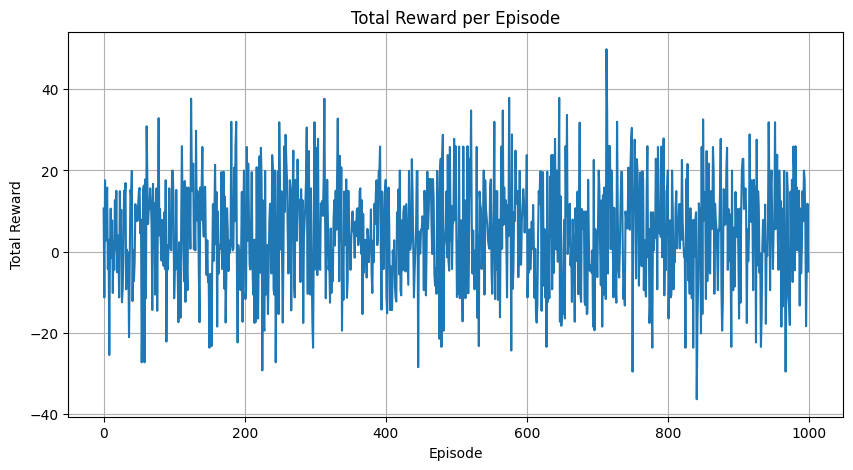

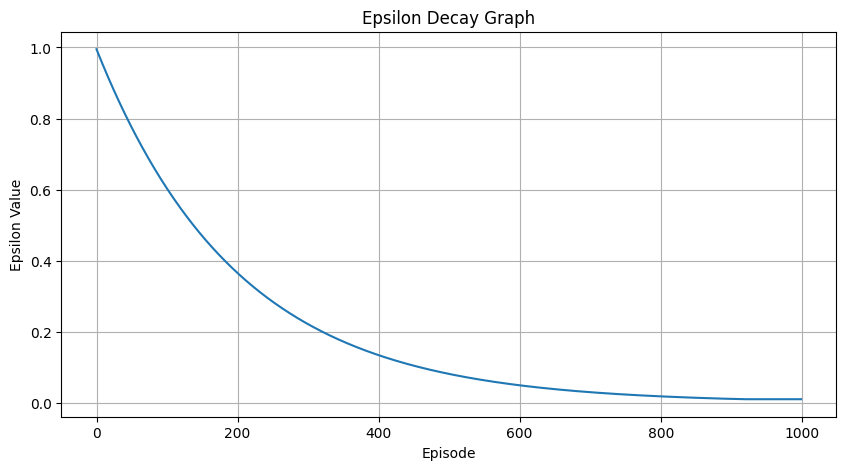

Episode 1000 Reward: 25.4
Episode 1000 Reward: 5.4
Episode 1000 Reward: 10.5
Episode 1000 Reward: 6.7
Episode 1000 Reward: 10.8
Episode 1000 Reward: -5.3
Episode 1000 Reward: -7.1
Episode 1000 Reward: 10.5
Episode 1000 Reward: -9.3
Episode 1000 Reward: 19.9


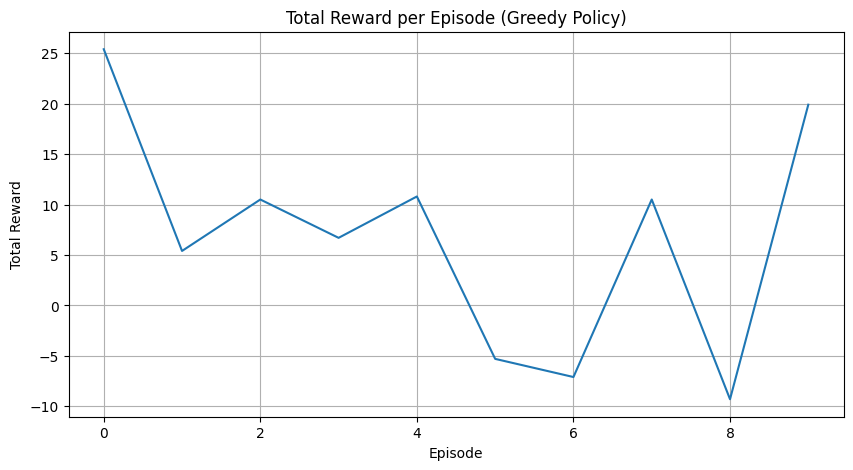

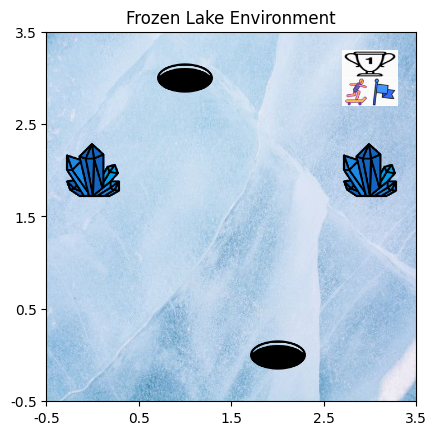

Max Timestamp, Gamma:  12, 0.5
Initial Q-table:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

Trained Q-table:
[[ 3.01958531e+00 -2.11095570e+00 -1.68838855e+00 -1.69432644e+00]
 [ 7.94443035e-01  1.19587005e+00  1.42542360e+00  4.32122737e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-3.19644764e+00 -3.25186245e+00  1.42587821e+00 -3.04979902e+00]
 [-3.83092556e+00 -3.93703425e+00 -3.48008442e+00 -1.20024546e+00]
 [ 6.11970059e-01 -1.98891402e-01 -1.29636967e-01 -1.12036659e-01]
 [ 2.91192524e-01 -2.91315411e+00 -3.02184394e+00 -3.11146202e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.04553583e+00 -1.85292521e+00 -1.55904580e+00 -1.42146563e+00]
 [ 1.51347665e+00  1.67

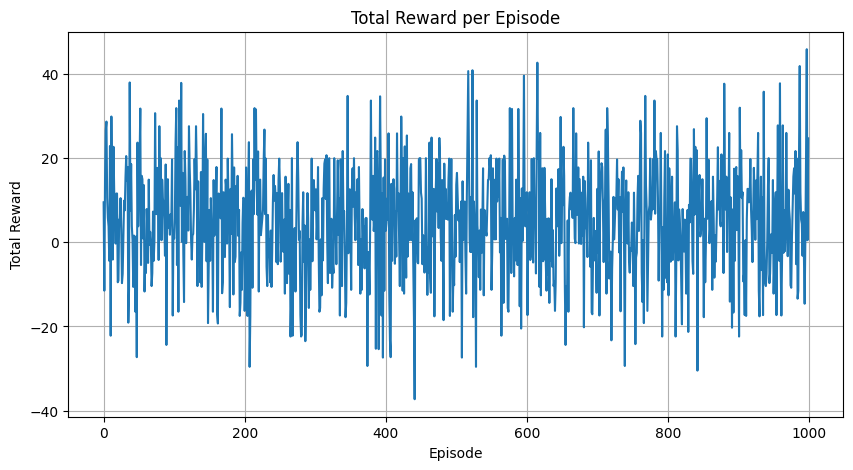

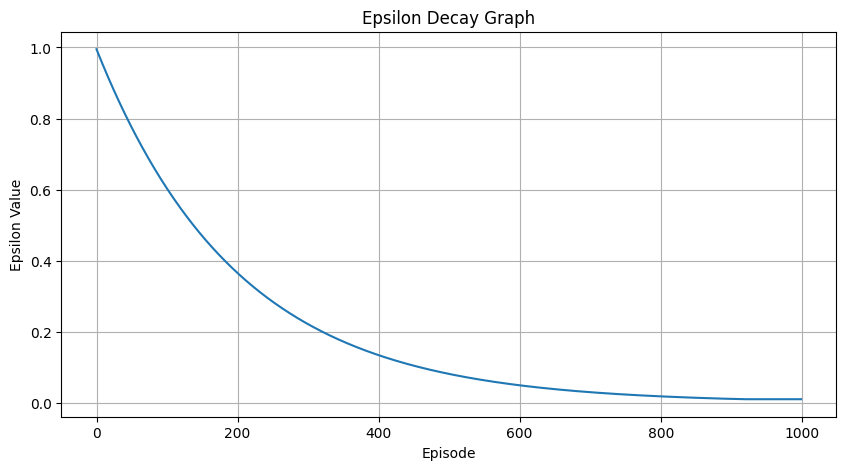

Episode 1000 Reward: 4.4
Episode 1000 Reward: -3.4
Episode 1000 Reward: 17.8
Episode 1000 Reward: -9.5
Episode 1000 Reward: 12.7
Episode 1000 Reward: -3.2
Episode 1000 Reward: 19.7
Episode 1000 Reward: 5.6
Episode 1000 Reward: 1.8
Episode 1000 Reward: 5.4


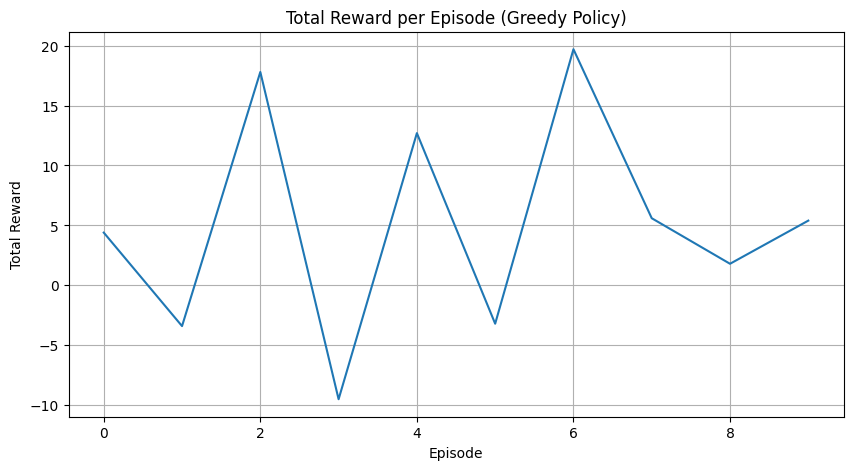

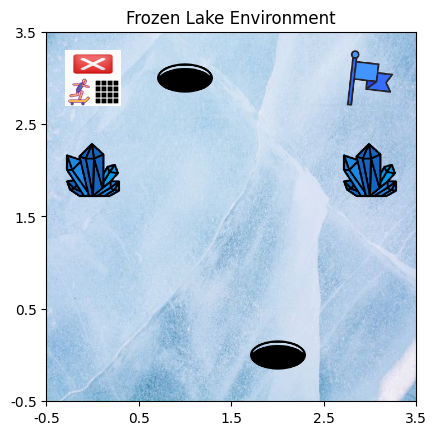

Max Timestamp, Gamma:  12, 0.9
Initial Q-table:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

Trained Q-table:
[[ 2.35322721  6.32530495  1.80534298  1.60097127]
 [ 4.85423918  6.71627864  5.02699491  5.63692627]
 [ 0.          0.          0.          0.        ]
 [-0.82905494  4.46716396 -1.15697825  1.09128701]
 [ 0.26179887  0.97437266  0.43294301  0.40196283]
 [ 3.11452504  2.82948168  3.46195166  5.85703266]
 [ 5.7368943   2.0095388   1.79328359  1.48350537]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.61420862  3.59652026  3.86760366  7.86606514]
 [ 6.56195677 10.40008308  6.31250849  7.04175957]
 [15.2674394   8.7133752   8.35344085  8.96323715]
 [ 0.82951577  0.83331878  0.51987552  1.8114758 ]
 [ 5.91480313  4.60880672  4.9

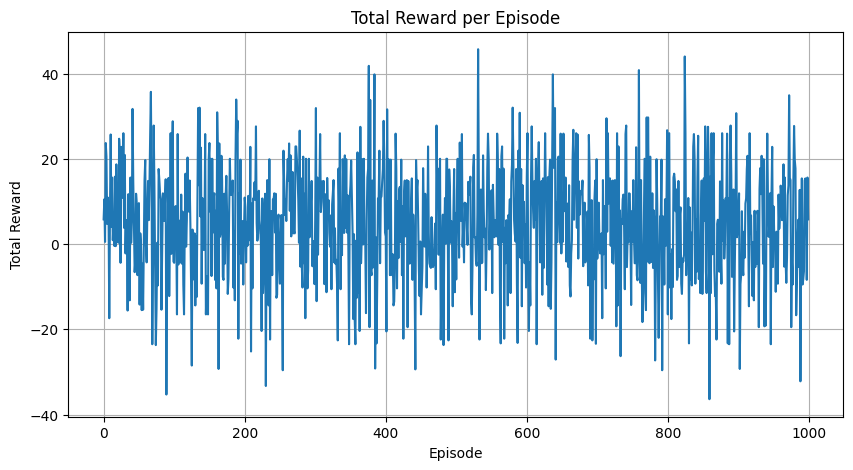

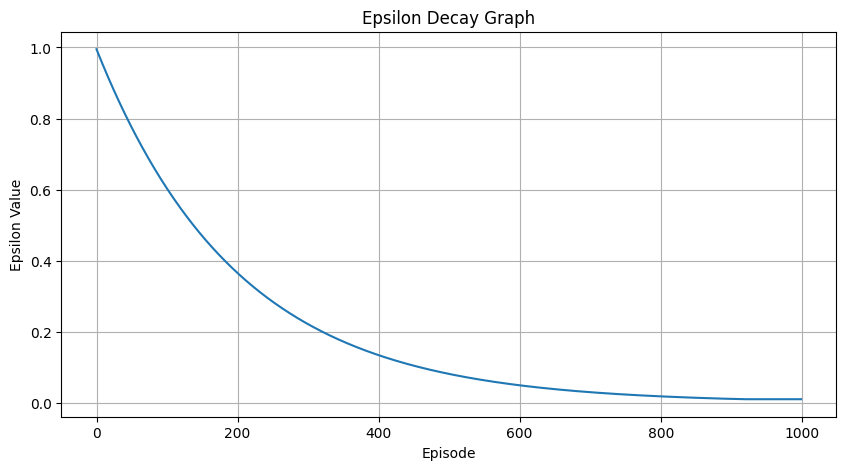

Episode 1000 Reward: -9.7
Episode 1000 Reward: 9.6
Episode 1000 Reward: 10.7
Episode 1000 Reward: -3.3
Episode 1000 Reward: -12.2
Episode 1000 Reward: -13.5
Episode 1000 Reward: -11.7
Episode 1000 Reward: -13.4
Episode 1000 Reward: 11.6
Episode 1000 Reward: 14.9


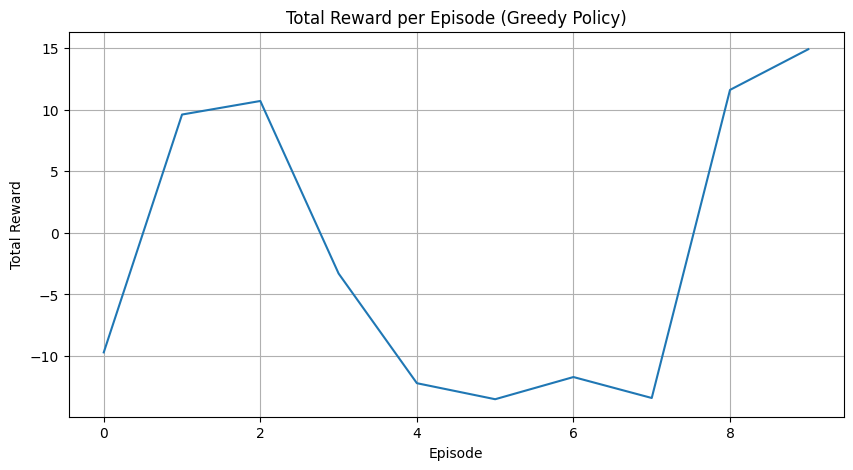

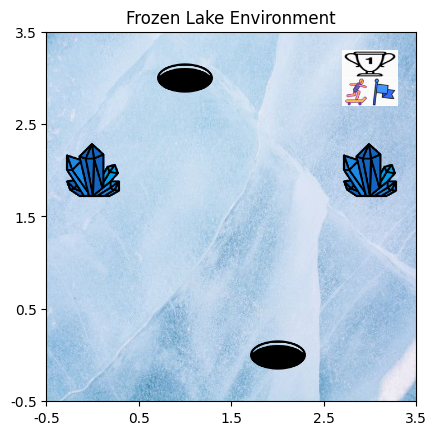

Max Timestamp, Gamma:  15, 0.1
Initial Q-table:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

Trained Q-table:
[[-0.73079696 -0.893346   -1.71152929 -1.37143854]
 [ 0.77530916  1.63046498  0.96154489  1.26272115]
 [ 0.          0.          0.          0.        ]
 [-2.73407294 -2.62471873 -0.20582906 -2.79305374]
 [-3.17145612 -4.32641696 -0.79620846 -4.26321314]
 [ 0.56841886 -0.23742308 -0.1935885  -0.22525736]
 [-1.38721637 -2.68127616 -2.47608751 -2.50516655]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [-0.58190265 -1.57710867 -1.78390285 -1.78649221]
 [ 0.40414636  0.21334554  1.44463837  3.10346726]
 [-0.85786141 -0.96794053 -1.12206369  7.75866241]
 [-2.81083575 -2.43090681 -0.22644202 -2.78055499]
 [ 1.73385612  0.01661328 -0.5

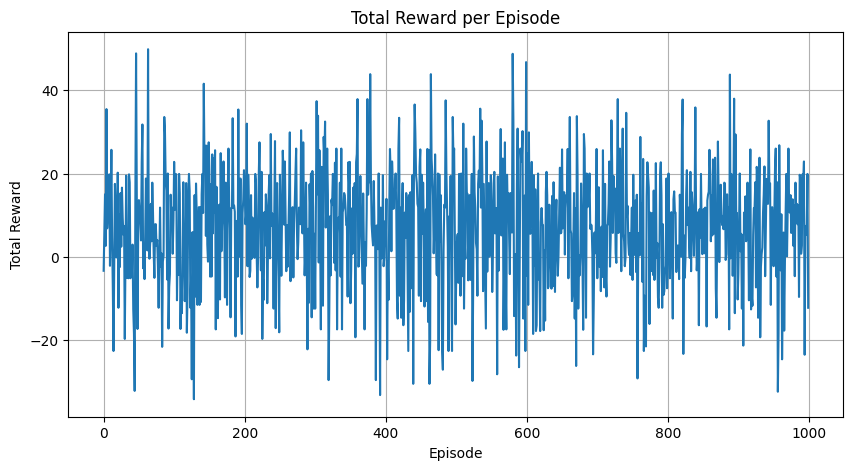

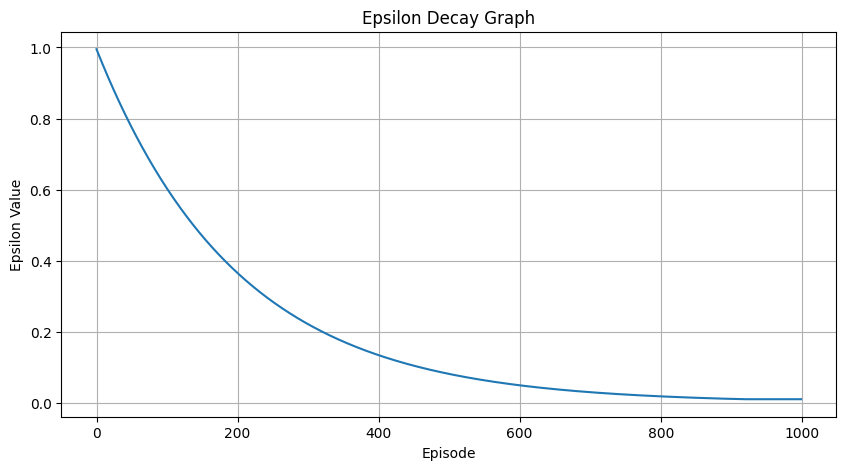

Episode 1000 Reward: 6.8
Episode 1000 Reward: 5.4
Episode 1000 Reward: 18.7
Episode 1000 Reward: 17.7
Episode 1000 Reward: 15.9
Episode 1000 Reward: 2.6
Episode 1000 Reward: 2.4
Episode 1000 Reward: 43.8
Episode 1000 Reward: 7.4
Episode 1000 Reward: 11.8


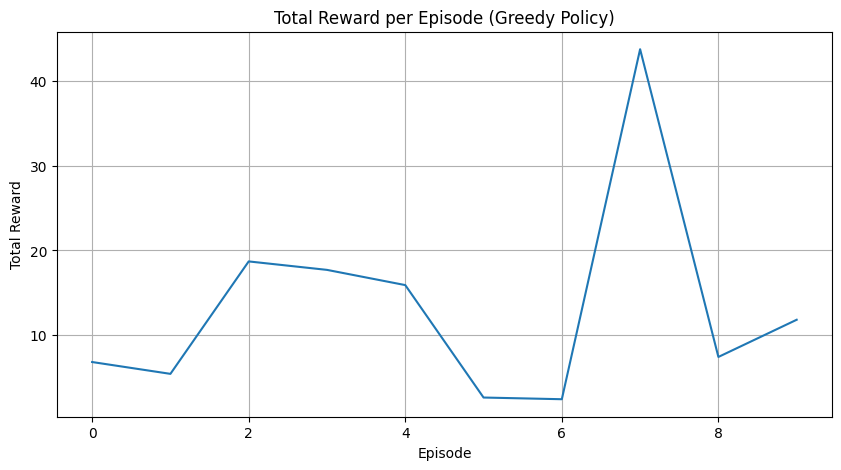

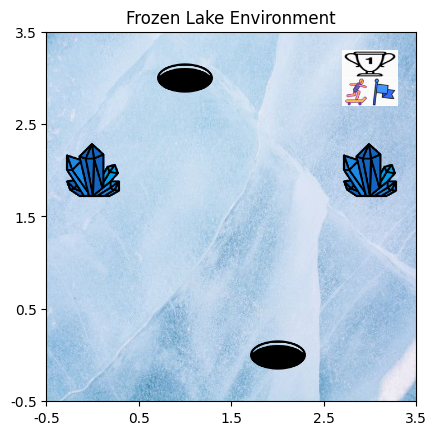

Max Timestamp, Gamma:  15, 0.5
Initial Q-table:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

Trained Q-table:
[[-1.87954854e+00 -1.64814303e+00 -7.40165958e-01 -1.54958397e+00]
 [ 1.57462442e+00  3.56083698e+00  1.60257620e+00  9.81956229e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.68483633e+00 -2.69108353e+00 -2.69750881e+00 -2.88812724e+00]
 [-3.82954893e+00 -3.68674531e+00 -3.48105165e+00 -2.18589179e+00]
 [ 9.88560174e-02  4.37172291e-01 -3.47491710e-03 -5.27928782e-02]
 [-2.50711407e+00 -2.33812617e+00 -2.49394287e+00  6.98730984e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-4.95807337e-01 -8.97270682e-01 -7.13022708e-01  2.29477713e-01]
 [ 8.55938479e-01  1.75

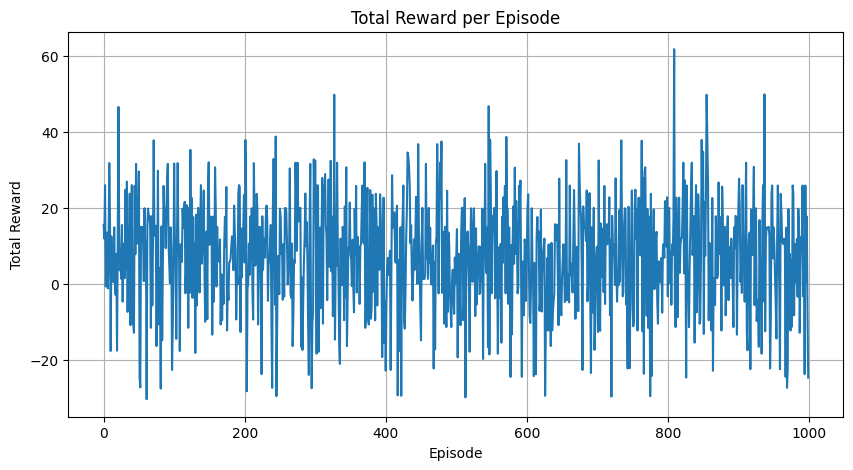

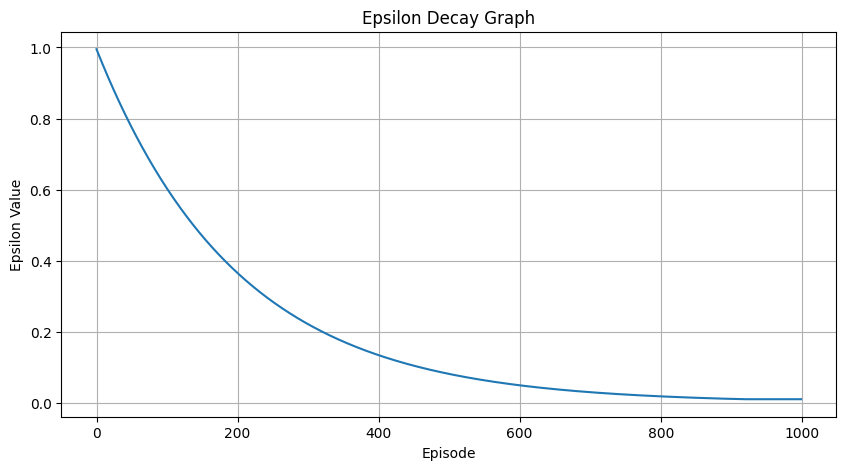

Episode 1000 Reward: 19.9
Episode 1000 Reward: -25.2
Episode 1000 Reward: 7.8
Episode 1000 Reward: -12.5
Episode 1000 Reward: -0.5
Episode 1000 Reward: 11.9
Episode 1000 Reward: 14.9
Episode 1000 Reward: -7.5
Episode 1000 Reward: 15
Episode 1000 Reward: -26.4


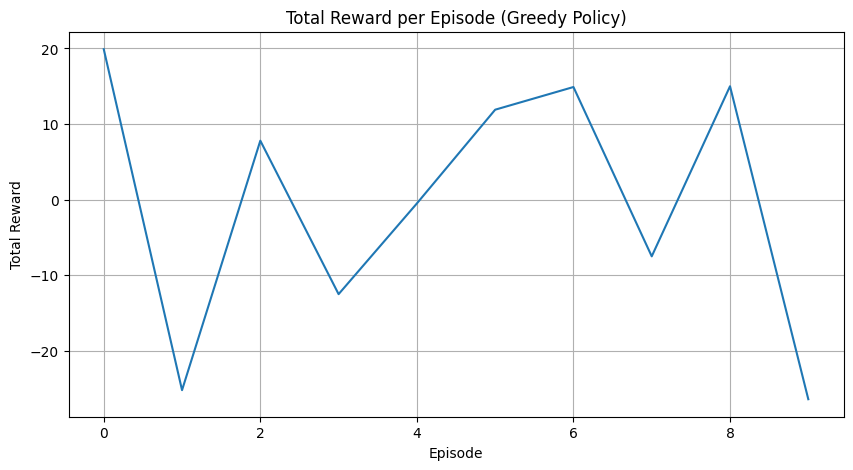

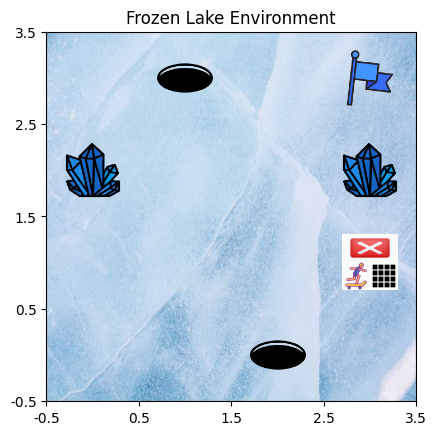

Max Timestamp, Gamma:  15, 0.9
Initial Q-table:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

Trained Q-table:
[[ 4.28450608  6.51811628  2.8420924   3.35134087]
 [ 5.48343708  6.59821933  6.61224956  7.65065879]
 [ 0.          0.          0.          0.        ]
 [ 0.72914475  3.0597191   0.67540427  1.07428669]
 [ 1.06276793  3.02423177  0.95753644  0.53272177]
 [ 4.66172044  4.64337893  5.34435816  4.04200704]
 [ 3.29209454  6.60435836  3.29963345  2.7767347 ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 6.34778916  5.00424317  4.73751385  5.39007003]
 [ 8.00398843  7.2842709  11.11172589  7.65320554]
 [ 7.18845392  6.75798479 17.81225236  7.46866309]
 [ 3.31269467  2.38445401  2.28786585  4.240887  ]
 [ 5.76576992  4.85508844  6.8

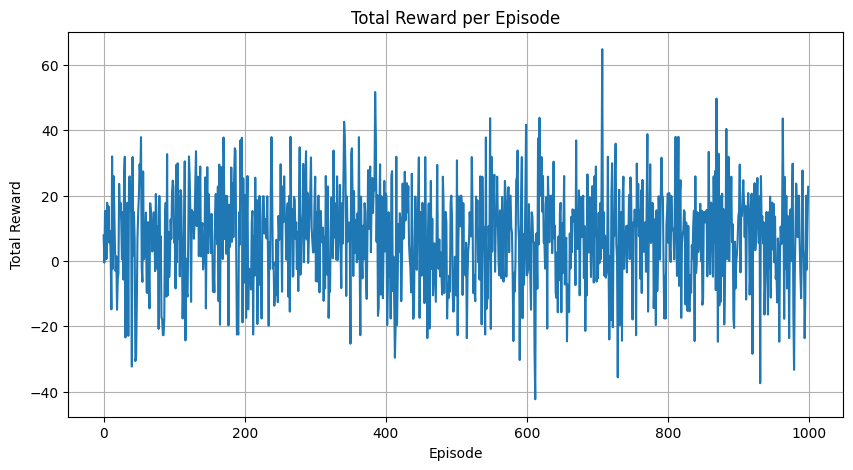

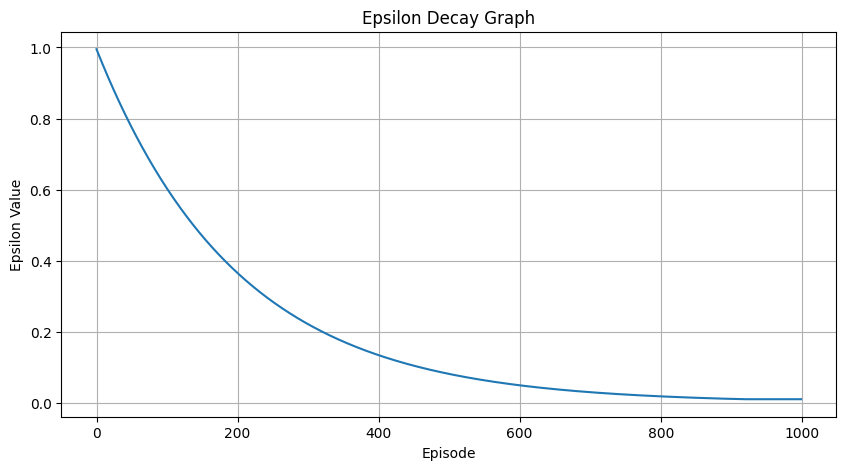

Episode 1000 Reward: 5.1
Episode 1000 Reward: 26
Episode 1000 Reward: -21.4
Episode 1000 Reward: -7.2
Episode 1000 Reward: 19.9
Episode 1000 Reward: 19.4
Episode 1000 Reward: 0.7
Episode 1000 Reward: 9.6
Episode 1000 Reward: 12.2
Episode 1000 Reward: 12.8


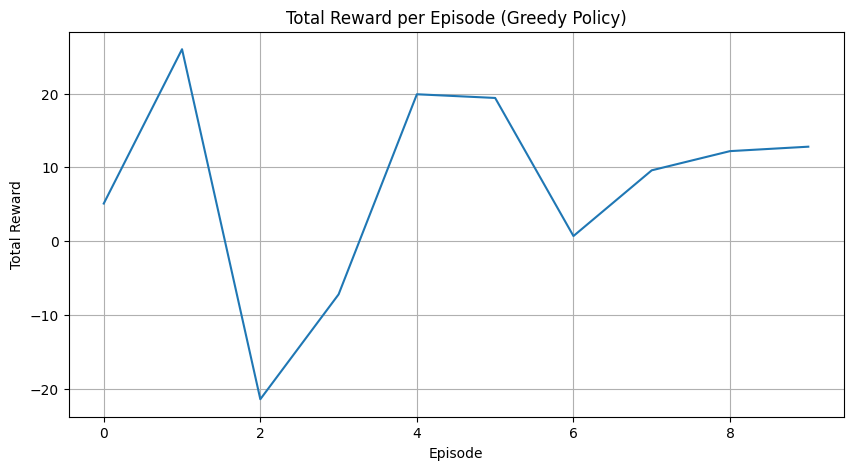

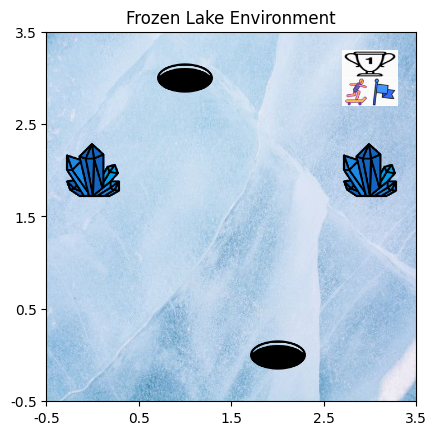

Max Timestamp, Gamma:  20, 0.1
Initial Q-table:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

Trained Q-table:
[[-2.26236879 -3.06983859 -3.0046934  -0.63719568]
 [ 0.80135215  0.8744352   2.40568916  0.83180565]
 [ 0.          0.          0.          0.        ]
 [-2.55638944 -1.3288844  -2.77969021 -2.52822582]
 [-4.0042086  -4.01068704 -3.75304855 -3.55358708]
 [-0.27412993  0.41423677 -0.24940895 -0.38307617]
 [-2.8980344  -2.05811534 -3.03662042 -2.93097228]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [-2.08685585 -0.70823354 -2.05025699 -2.33886327]
 [ 0.53339227  0.83430623  0.05649331  1.9588543 ]
 [-0.46861326  5.52155998 -0.50697882 -1.3518547 ]
 [-1.65687202 -1.1850704  -1.94698079 -1.8283448 ]
 [ 0.78886274  1.78598283  0.7

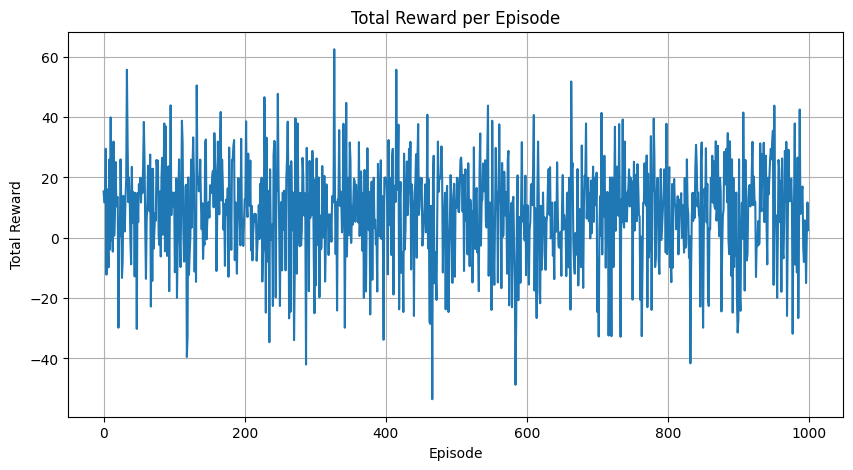

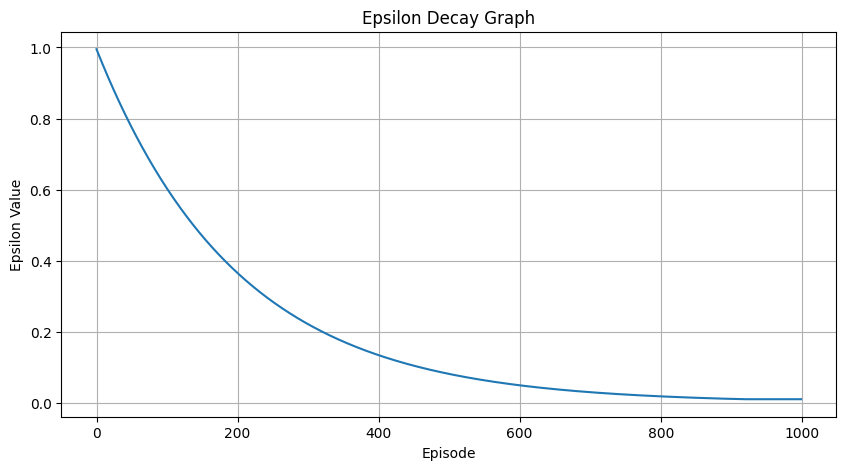

Episode 1000 Reward: 18.6
Episode 1000 Reward: 5.6
Episode 1000 Reward: 7.3
Episode 1000 Reward: 44.4
Episode 1000 Reward: 15.7
Episode 1000 Reward: -2.8
Episode 1000 Reward: 6.9
Episode 1000 Reward: 5.5
Episode 1000 Reward: 22.2
Episode 1000 Reward: -4.7


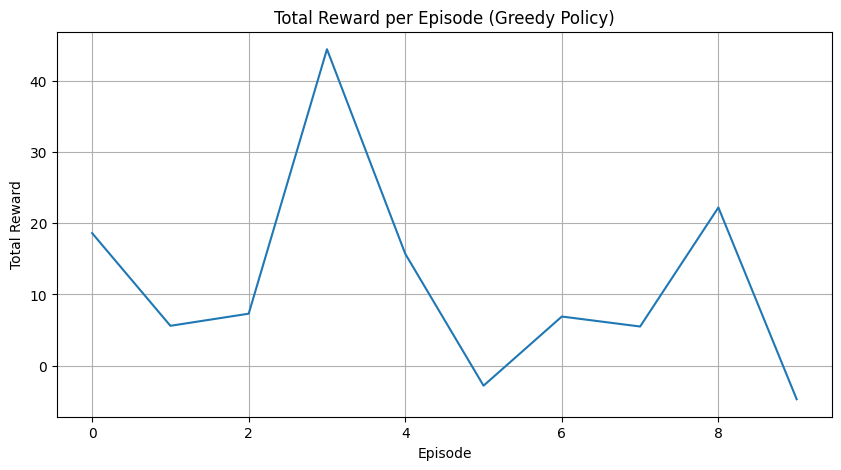

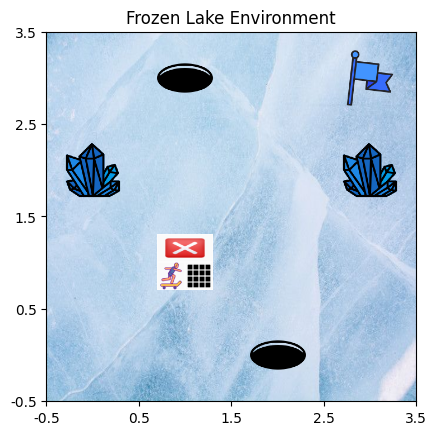

Max Timestamp, Gamma:  20, 0.5
Initial Q-table:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

Trained Q-table:
[[ 4.0298578  -2.26345228 -2.08439175 -1.52996574]
 [ 0.65820455  1.53426055  1.46630808  1.49405592]
 [ 0.          0.          0.          0.        ]
 [-2.66522358 -1.60163318 -2.42326533 -2.4645201 ]
 [-3.44025831 -3.28445825 -1.56550575 -3.26489078]
 [ 0.40321783 -0.07283639 -0.04281927 -0.16467327]
 [-2.4354133   0.92720904 -2.30927059 -2.35598494]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [-0.91095873  2.68700534 -0.97219551 -0.71990449]
 [ 1.22779878  1.61472063  4.42583717  1.50652455]
 [-0.17887925 -0.44935924  6.55764752 -0.45747638]
 [-2.14071225 -2.08786999 -2.32865291 -2.08514796]
 [ 0.43992406  0.55234157  0.3

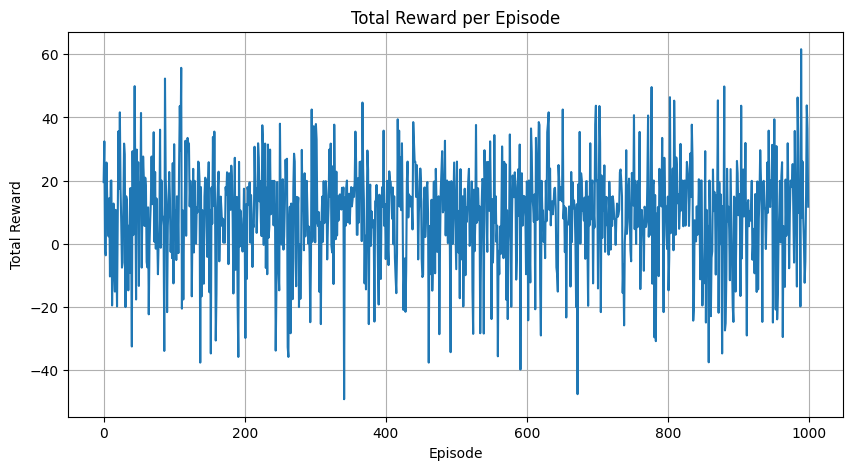

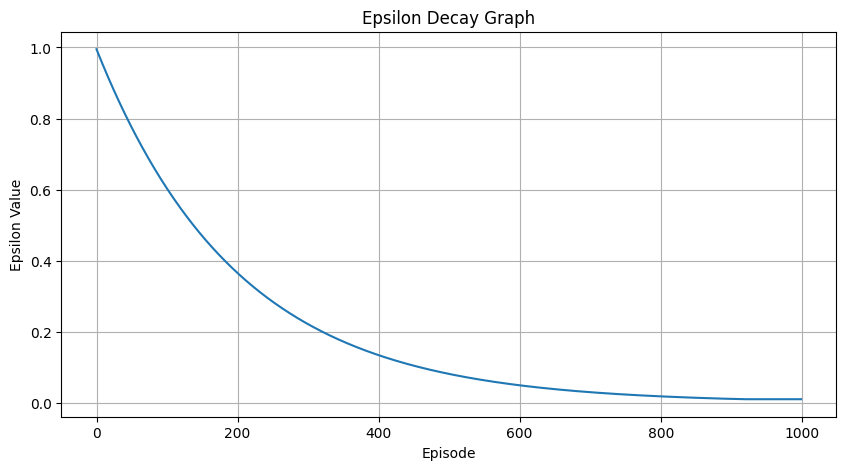

Episode 1000 Reward: 19.7
Episode 1000 Reward: 23.9
Episode 1000 Reward: 17.7
Episode 1000 Reward: 3.3
Episode 1000 Reward: 20.7
Episode 1000 Reward: -24.7
Episode 1000 Reward: 7.8
Episode 1000 Reward: -8.7
Episode 1000 Reward: 5.7
Episode 1000 Reward: 17.8


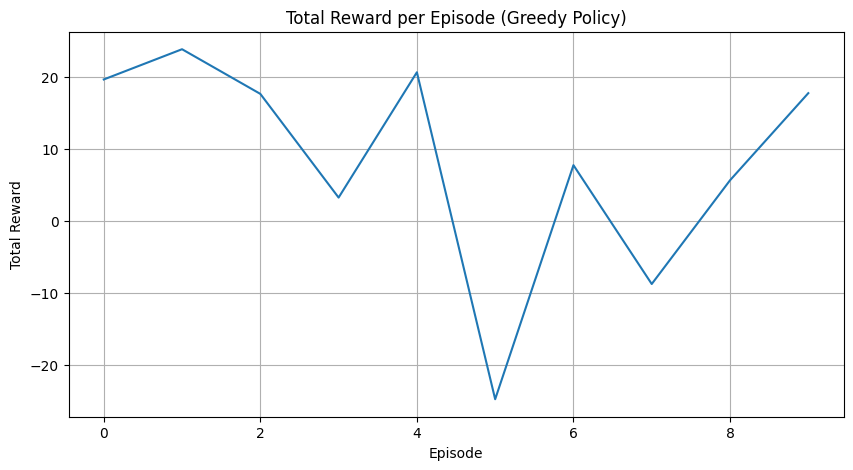

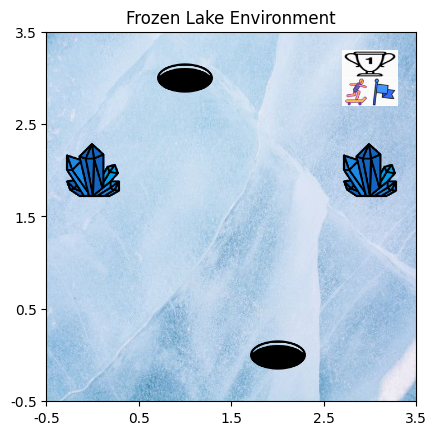

Max Timestamp, Gamma:  20, 0.9
Initial Q-table:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

Trained Q-table:
[[ 2.50108166  8.50134581  3.32232397  3.52052373]
 [ 6.52682463  6.536674    6.35517236  7.92101982]
 [ 0.          0.          0.          0.        ]
 [ 1.32882155  1.61241732  1.08855848  7.68147709]
 [ 1.07325979  4.31886988  1.30033298  0.76906247]
 [ 5.08589206  4.2800834   6.88733768  5.0128677 ]
 [ 5.67220036  3.44178405  3.63058045  3.15167601]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 8.77512057  4.75503141  4.87612439  5.12225693]
 [ 7.98585357  7.72400233 11.68757973  8.14478469]
 [ 8.48713999 12.98351823  7.44619316  7.60312939]
 [ 2.96430022  2.47155241  2.65550762  3.81767341]
 [ 7.00245511  9.93624667  7.1

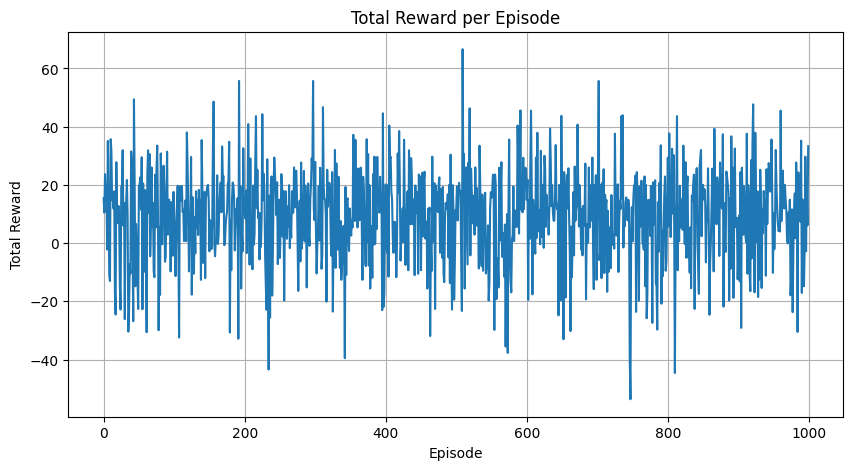

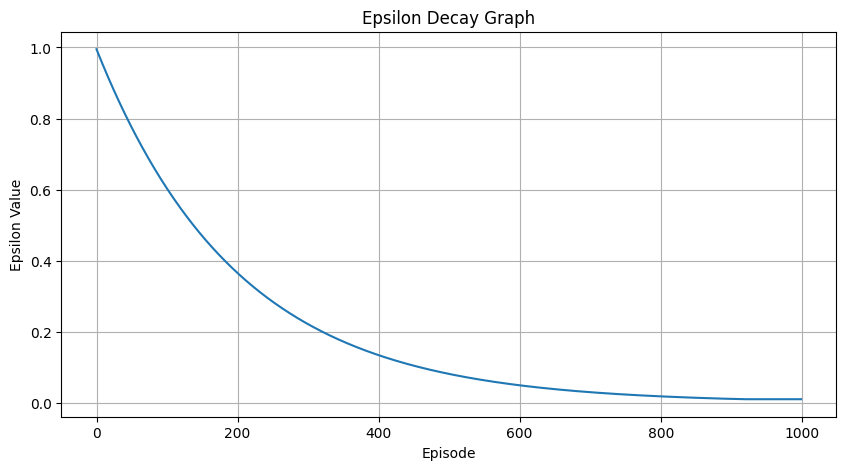

Episode 1000 Reward: -10.2
Episode 1000 Reward: 35.4
Episode 1000 Reward: -0.7
Episode 1000 Reward: 7.1
Episode 1000 Reward: 31.8
Episode 1000 Reward: -16.9
Episode 1000 Reward: 31.7
Episode 1000 Reward: 15.2
Episode 1000 Reward: 11.7
Episode 1000 Reward: -0.9


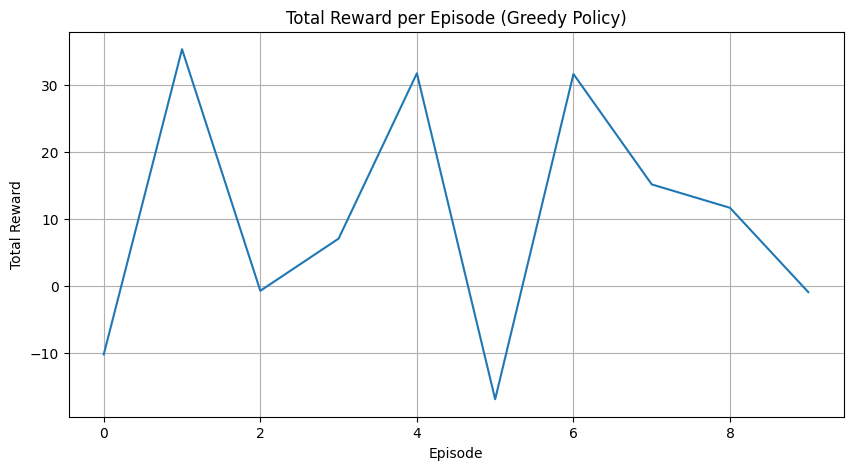

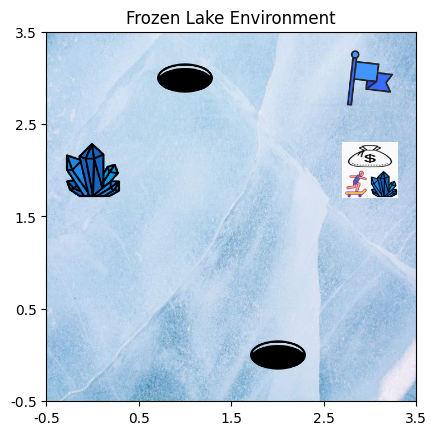

In [13]:
max_timestamp_values = [12, 15, 20]
gamma_values = [0.1, 0.5, 0.9]

for mt in max_timestamp_values:
    for gamma in gamma_values:
        env_stoc = StochasticFrozenLakeEnv(gamma=gamma, alpha=0.15, max_timestamp=mt)
        qt, rewards_epi, epsilon_values, final_state = training_loop(env_stoc, gamma, mt)
        evaluate_loop(env_stoc, mt, gamma, qt, rewards_epi, epsilon_values, final_state)